In [9]:
%run Read_Tuolumne_data.ipynb

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    name: ASO Tuolumne basin machine learning and geostatistics data set
    contains: SWE depth maps from 16 Airborne Snow Observatory lidar scans (2016-2019)  and "static" terrain parameters from the SRTM DEM and the National Land Cover Database
    location: Tuolumne basin (around Hetch Hetch Reservoir), in the Californian Sierra Nevada
    time period: Multiple flights in the snow seasons 2016, 2017, 2018, and 2019
    georeferencing: Pixels/cells are regularly spaced in zone 11S of the UTM projection based on the WGS84 ellipsoid.
    convention: By convention, the first pixel (i.e.: row index i=1, column index j=1) is in the upper left corner of the image.
    dimensions: The image stack "D" (SWE maps) have 3 dimensions [dim1=rows=y_i=northing, dim2=columns=x_j=easting, dim3=t_n=time of flight]
    Ground sampling distance: GSD=100 meters (spatial resolution)
    easting coordinate: The easting p

In [10]:
def scale(xtrain, xtest):
    """
    Scales the data using the StandardScaler from SKLearn.

    INPUT:
    xtrain, xtest: Unscaled design matrices (We scale using the first input)

    OUTPUT:
    xtrain_scaled, xtest_scaled: Scaled design matrices
    """

    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain_scaled = scaler.transform(xtrain); xtrain_scaled[:,0] = 1
    xtest_scaled = scaler.transform(xtest); xtest_scaled[:,0] = 1

    return xtrain_scaled, xtest_scaled

def DesignMatrixCreator_2dpol(p,x,y):
    """
    Creates a design matrix for 2 variable polynomial (x,y)

    INPUT:
    p: Degree of polynomial
    x, y: Array of x-values & y-values

    OUTPUT:
    X: Design matrix
    """

    if len(x) != len(y):
        sys.exit(0)

    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    num_of_terms = int(((p+1)*(p+2))/2)

    X = np.zeros([N,num_of_terms])
    X[:,0] = 1
    column = 1
    for i in range(1,p+1):
        for j in range(i+1):
            X[:,column] = (x**j)*(y**(i-j))
            column += 1
    return X

In [31]:
"""Initialize the test and training datasets to use for varying number of trees, and varying number of estimators
    Only use 1 of the 16 passes in order for the regression to be finished in a reasonable amount of time"""
X = np.transpose(np.array([svf_clean,z_clean,northness_clean,eastness_clean,slp_clean,cc_clean]))#create matrix of all predicators
#x_train, x_test, y_train, y_test = train_test_split(X,D_clean[:,0],test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(X,D_clean,test_size=0.2)
x_train, x_test = scale(x_train, x_test)

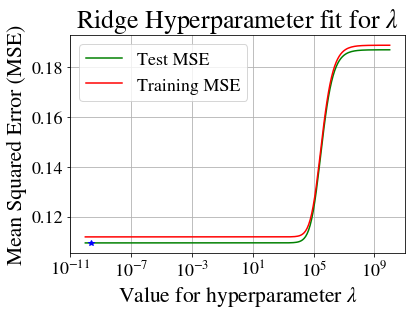

In [38]:
from sklearn.linear_model import Ridge

def Ridge_reg(X_basin,XTraining, XValidate, yTraining, yValidate,lamb,validate_testsize=0.2):
    """
    Performs Ridge regression on a data set and finds the optimal hyperparameter

    INPUT:
    XTrain: The scaled design matrix corresponding to the train values
    XTest: The scaled design matrix corresponding to the test values
    yTrain: The "true" data values of the train data
    yTest: The "true" data values of the test data
    lamb: an array of potential lambda values we are optimizing for
    validate_testsize: (Optional) The amount of the full data set should be set aside for testing

    OUTPUT:
    ytildeTest: Approximated values corresponding to the test data
    ytildeTrain: Approximated values corresponding to the train data
    Beta_Ridge_Optimal: The optimal coefficient values for the best-fit polynomial using Ridge
    optimalLambda: The optimal value for lambda (where the MSE value is the lowest)
    MSE_lamb: An array with the same length as lambda, contains Mean Squared Errors of said lambda values
    MSEPredict: Same as MSE_lamb, but for SKLearns model
    """

    """
    Comparing Our Ridge to SKLearns
    """

    MSETest = np.zeros(len(lamb))
    #MSEPredictSKL = np.zeros(len(lamb))
    MSETrain = np.zeros(len(lamb))
    for i,lambval in enumerate(lamb):
        lmb = lambval
        # add ridge
        skl_ridge = Ridge(alpha=lmb).fit(XTraining, yTraining)
        yridge_test = skl_ridge.predict(XValidate)
        yridge_train = skl_ridge.predict(XTraining)
        yridge_basin = skl_ridge.predict(X_basin)
        # and then make the prediction
        MSETest[i] = metric.mean_squared_error(yValidate,yridge_test)
        MSETrain[i] = metric.mean_squared_error(yTraining,yridge_train)
        
    skl_ridge = Ridge(alpha=10).fit(XTraining, yTraining)
    yridge_test = skl_ridge.predict(XValidate)
    yridge_train = skl_ridge.predict(XTraining)
    yridge_basin = skl_ridge.predict(X_basin)
    return yridge_basin,yridge_test, yridge_train, MSETest,MSETrain

PolyDeg = 5 #Fix the polynomial degree

lambdavals = np.logspace(-10,10,200) #Create an array of lambda values.


yridge_basin, ytilde_Test, ytilde_Train, MSE_Test,MSE_Train = Ridge_reg(X,x_train,x_test,y_train,y_test,lambdavals) #Perform Ridge
min_idx = np.argmin(MSE_Test)
#Plot MSE vs hyperparameter
plt.plot(lambdavals,MSE_Test,label="Test MSE",color = 'g')
plt.plot(lambdavals[min_idx],MSE_Test[min_idx],'*',color = 'b')
plt.plot(lambdavals,MSE_Train, label = 'Training MSE', color = 'r')
#plt.axvline(OptLamb,label="$\lambda = $%e"%OptLamb,color = 'r')
plt.semilogx();
plt.grid()
plt.xlabel("Value for hyperparameter $\lambda$",fontsize="large")
plt.ylabel("Mean Squared Error (MSE)",fontsize="large")
plt.title("Ridge Hyperparameter fit for $\lambda$",fontsize="x-large")
plt.legend()
plt.show()




(160791, 16)


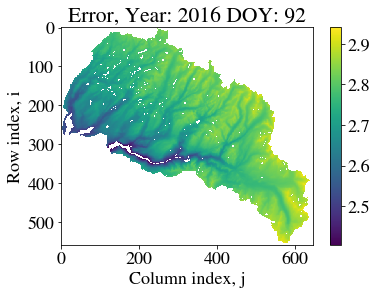

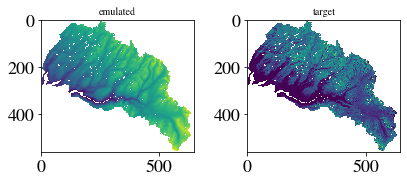

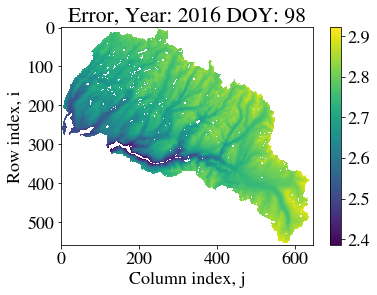

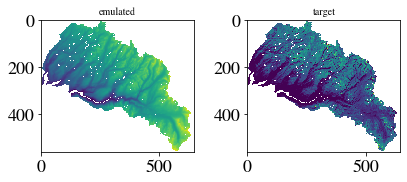

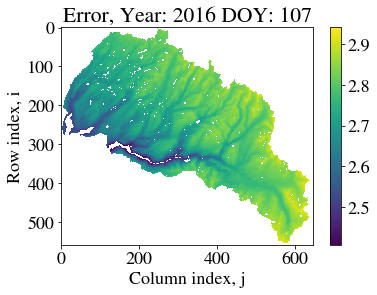

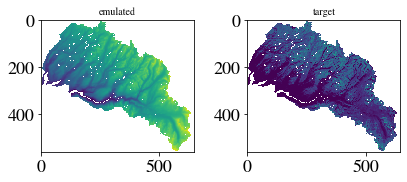

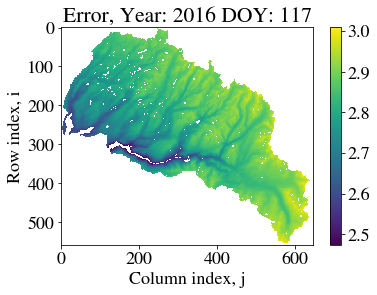

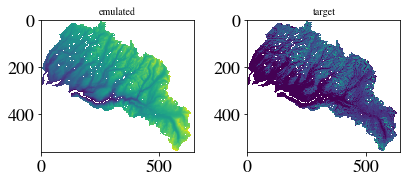

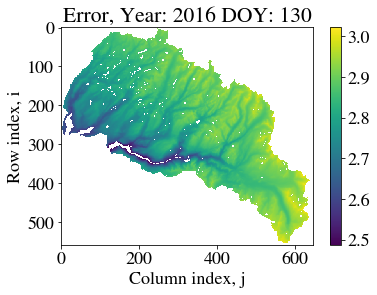

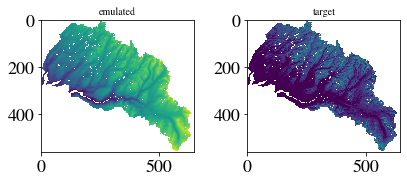

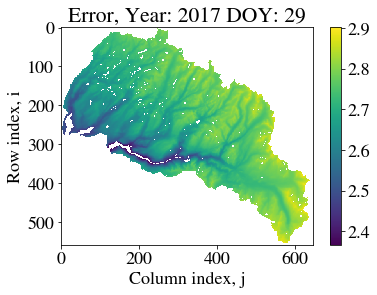

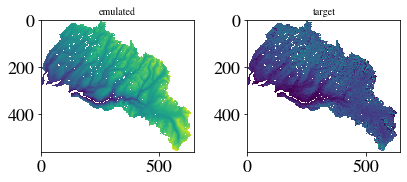

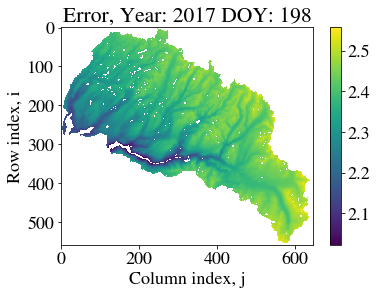

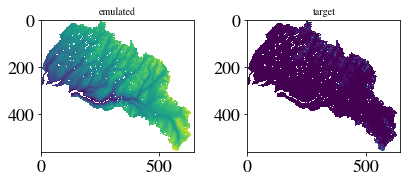

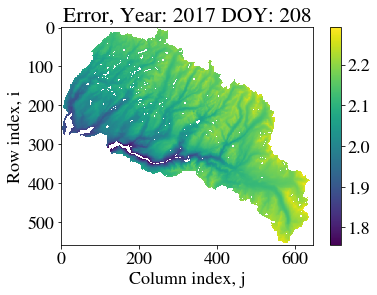

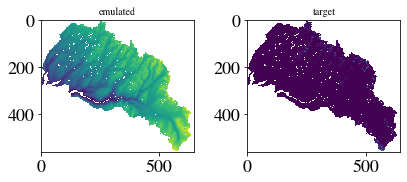

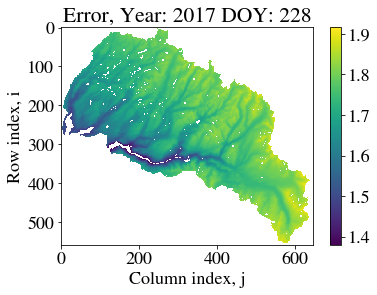

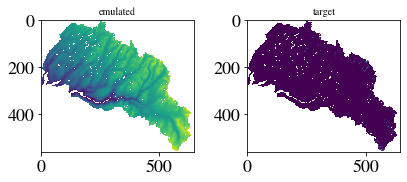

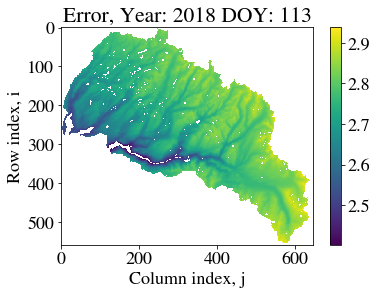

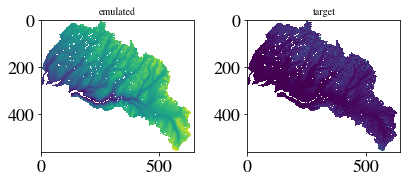

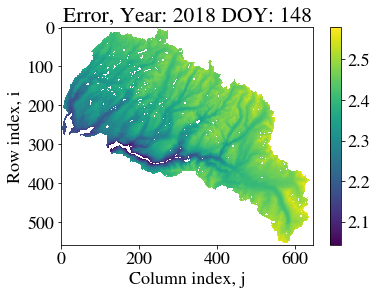

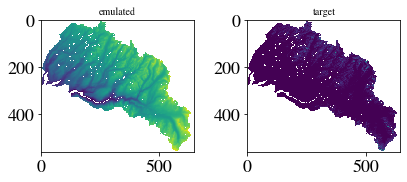

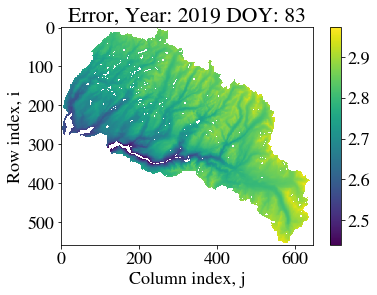

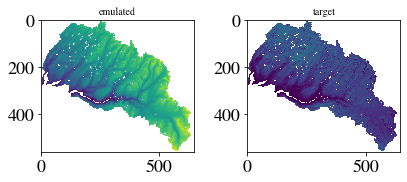

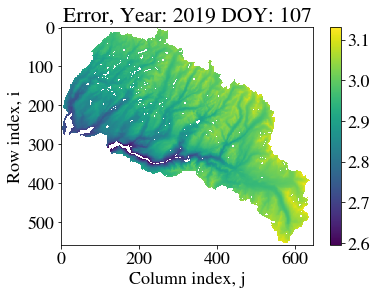

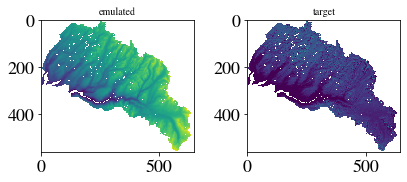

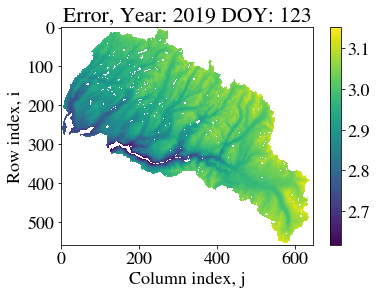

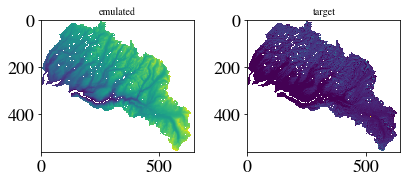

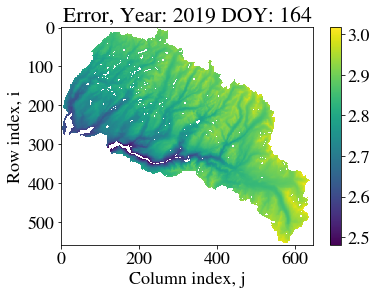

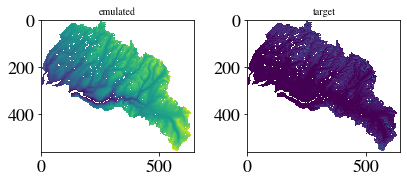

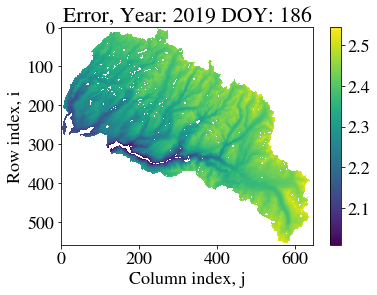

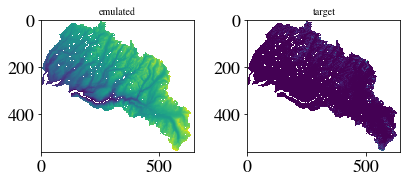

In [33]:
#Map back to coordinates for visualization
D_pred=np.zeros_like(D)

print(yridge_basin.shape)

for i in range(D.shape[2]):
    D_pred[not_nan,i]=yridge_basin[:,i]
    D_pred[~not_nan,i]=np.nan
    
    plt.figure()
    cm=plt.imshow(np.log10(np.abs(D_pred[:,:,i]-D[:,:,i])))
    plt.title('Error, Year: '+str(year[i])+' DOY: ' + str(DOY[i]))
    plt.ylabel('Row index, i')
    plt.xlabel('Column index, j')
    plt.colorbar()
    plt.show()

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(D_pred[:,:,i])
    #axs[0].axis('equal')
    axs[0].set_title('emulated', fontsize=10)
    axs[1].imshow(D[:,:,i])
    #axs[1].axis('equal')
    axs[1].set_title('target', fontsize=10)

    fig.tight_layout()
    #plt.close('all')

In [ ]:


def Ridge()
    lambdavals = np.logspace(-10,5,100) #Create an array of lambda values
    XTraining, XValidate, yTraining, yValidate = train_test_split(XTrain,yTrain,test_size=validate_testsize)
    """
    SKL Ridge
    """
    MSEPredictSKL = np.zeros(len(lamb))
    MSETrain = np.zeros(len(lamb))
    for i,lambval in enumerate(lamb):
        lmb = lambval
        # add ridge
        clf_ridge = skl.Ridge(alpha=lmb).fit(XTraining, yTraining)
        yridge = clf_ridge.predict(XValidate)
        Ridgebeta = np.linalg.inv(XTraining.T @ XTraining+lmb*I) @ XTraining.T @ yTraining
        # and then make the prediction
        ytildeRidge = XTraining @ Ridgebeta
        ypredictRidge = XValidate @ Ridgebeta
        MSEPredict[i] = MSE(yValidate,ypredictRidge)
        MSEPredictSKL[i] = MSE(yValidate,yridge)
        MSETrain[i] = MSE(yTraining,ytildeRidge)

    

MaxPoly = 20 #Maximum polynomial degree
lamb = np.logspace(-10,5,100) #Create an array of lambda values

MSE_train_array = np.zeros(MaxPoly) #Create empty arrays to be filled with interesting data.
MSE_test_array = np.zeros(MaxPoly)

for polydeg in range(1,MaxPoly+1): #Run through all polynomial degrees
            X_train, X_test = scale(X_train, X_test)

            z_tilde_test, z_tilde_train, Beta_Ridge, optimalLambda, MSE_lamb, MSE_lamb_skl = Ridge(X_train,X_test,z_train,z_test,lambdavals) #Perform the Ridge method

            MSE_train_array[polydeg-1] = MSE(z_train,z_tilde_train) #Fill the arrays with interesting data
            MSE_test_array[polydeg-1] = MSE(z_test,z_tilde_test)
            print(polydeg) #Leave this in to get a feel for how long the program has come (it takes a while to run)

        polydegs = np.arange(1,MaxPoly+1) #Plot the MSE for test and training data together with polynomial degree
        plt.figure()
        plt.plot(polydegs,MSE_train_array,label="Train")
        plt.plot(polydegs,MSE_test_array,label="Test")
        plt.xlabel("'Complexity' of model (Polynomial degree)",fontsize="large")
        plt.ylabel("Mean Squared Error (MSE)",fontsize="large")
        plt.title("N = %i, test size = %.1f%%, noise = %.2f\nRidge Shrinkage Method"% (N,testsize*100,noise),fontsize="x-large")
        plt.grid(); plt.legend(); plt.semilogy()
        plt.show()